In [ ]:
!pip install praw

In [ ]:
!pip install praw pandas

In [ ]:
!pip install asyncpraw

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
!pip install nest_asyncio

In [ ]:
import asyncio
import asyncpraw
import pandas as pd
import nest_asyncio  # Add this line
nest_asyncio.apply()  # Apply nest_asyncio

async def fetch_reddit_comments():
    reddit = asyncpraw.Reddit(
        client_id="",
        client_secret="",
        user_agent="football-data-collector/0.1 by nyk_script"
    )
    subreddit = await reddit.subreddit("Championsleague")
    comments = []

    async for submission in subreddit.hot(limit=50):
        await submission.load()
        for top_level_comment in submission.comments:
            if isinstance(top_level_comment, asyncpraw.models.Comment):
                comments.append(top_level_comment.body)

    df = pd.DataFrame(comments, columns=["Comment"])
    df.to_csv("Football_comments_raw.csv", index=False)
    print(f"Raw comments saved! Total: {len(comments)}")
    await reddit.close()

async def clean_data():
    df = pd.read_csv("Football_comments_raw.csv")
    df.drop_duplicates(subset="Comment", inplace=True)
    df = df[df["Comment"].str.len() > 5]
    df.loc[:, "Comment"] = df["Comment"].str.lower().str.replace(r'[^\w\s]', '', regex=True)
    df.to_csv("Football_comments_cleaned.csv", index=False)
    print(f"Data cleaned and saved! Total: {len(df)}")

async def main():
    await fetch_reddit_comments()
    await clean_data()

# Run the workflow
asyncio.run(main())

Raw comments saved! Total: 2901
Data cleaned and saved! Total: 2697


In [ ]:
from textblob import TextBlob
import pandas as pd

# Load the cleaned data
df = pd.read_csv("Football_comments_cleaned.csv")

# Ensure all comments are strings
df = df[df["Comment"].notnull()]  # Remove NaN values
df["Comment"] = df["Comment"].astype(str)

# Add sentiment scores
df["Sentiment"] = df["Comment"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Categorize sentiment
def categorize_sentiment(score):
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    else:
        return "Neutral"

df["Sentiment Category"] = df["Sentiment"].apply(categorize_sentiment)

# Save results
df.to_csv("Football_comments_with_sentiment.csv", index=False)
print("Sentiment analysis complete!")

Sentiment analysis complete!


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Load the cleaned data
df = pd.read_csv("Football_comments_cleaned.csv")

# Ensure valid text data
df = df[df["Comment"].notnull()]
df["Comment"] = df["Comment"].astype(str)

# Apply Bag of Words
vectorizer = CountVectorizer(max_features=1000, stop_words="english")  # Limit to top 1000 words
bow_matrix = vectorizer.fit_transform(df["Comment"])

# Convert BoW matrix into a DataFrame
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Display the first few rows
print(bow_df.head())

# Save the BoW matrix to a CSV
bow_df.to_csv("Football_comments_bow.csv", index=False)
print("Bag of Words representation saved!")

   04  05  07  10  100  10th  11  12  15  16  ...  year  years  yes  youll  \
0   0   0   0   0    0     0   0   0   0   0  ...     0      0    0      0   
1   0   0   0   0    0     0   0   0   0   0  ...     0      0    0      0   
2   0   0   0   0    0     0   0   0   0   0  ...     0      0    0      0   
3   0   0   0   1    0     0   0   0   0   0  ...     0      1    0      0   
4   0   0   0   0    0     0   0   0   0   0  ...     0      0    0      0   

   young  youre  youtube  youve  zero  zidane  
0      0      0        0      0     0       0  
1      0      0        0      0     0       0  
2      0      0        0      0     0       0  
3      0      0        0      0     0       0  
4      0      0        0      0     0       0  

[5 rows x 1000 columns]
Bag of Words representation saved!


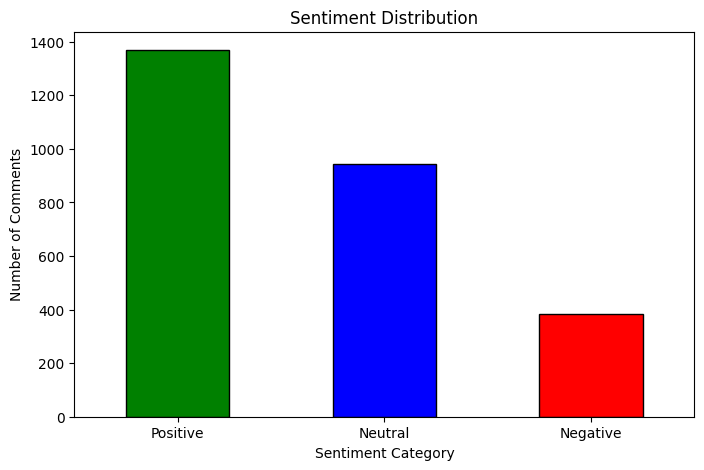

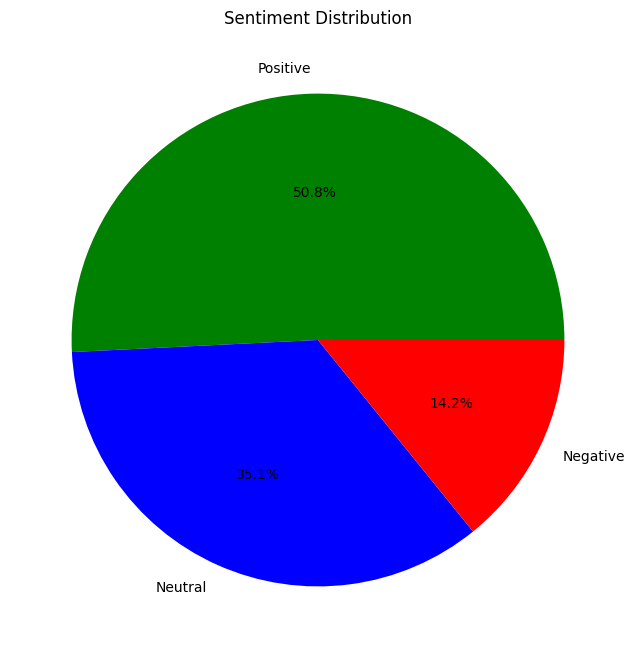

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset with sentiment results
df = pd.read_csv("Football_comments_with_sentiment.csv")

# Count the occurrences of each sentiment category
sentiment_counts = df["Sentiment Category"].value_counts()

# Bar Chart for Sentiment Distribution
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind="bar", color=["green", "blue", "red"], edgecolor="black")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)
plt.show()

# Pie Chart for Sentiment Distribution
plt.figure(figsize=(8, 8))
sentiment_counts.plot(kind="pie", autopct="%1.1f%%", colors=["green", "blue", "red"])
plt.title("Sentiment Distribution")
plt.ylabel("")  # Remove y-axis label for clarity
plt.show()

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("Football_comments_cleaned.csv")

# Ensure all comments are strings and remove NaN values
df = df[df["Comment"].notnull()]  # Remove rows with NaN values
df["Comment"] = df["Comment"].astype(str)  # Convert all entries to strings

# Tokenize the comments
df["Tokens"] = df["Comment"].apply(lambda x: x.split())

# Verify the tokens
print(df["Tokens"].head())

0    [fellow, fans, this, is, a, friendly, reminder...
1    [liverpool, fans, are, allowed, to, not, like,...
2          [city, being, good, united, being, rubbish]
3    [what, do, you, mean, two, dudes, shared, all,...
4    [definitely, messi, and, ronaldo, before, that...
Name: Tokens, dtype: object


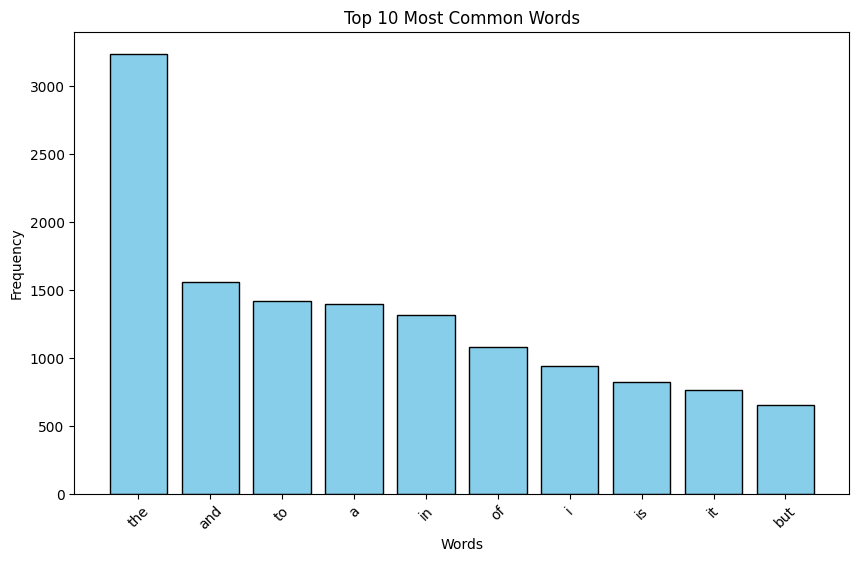

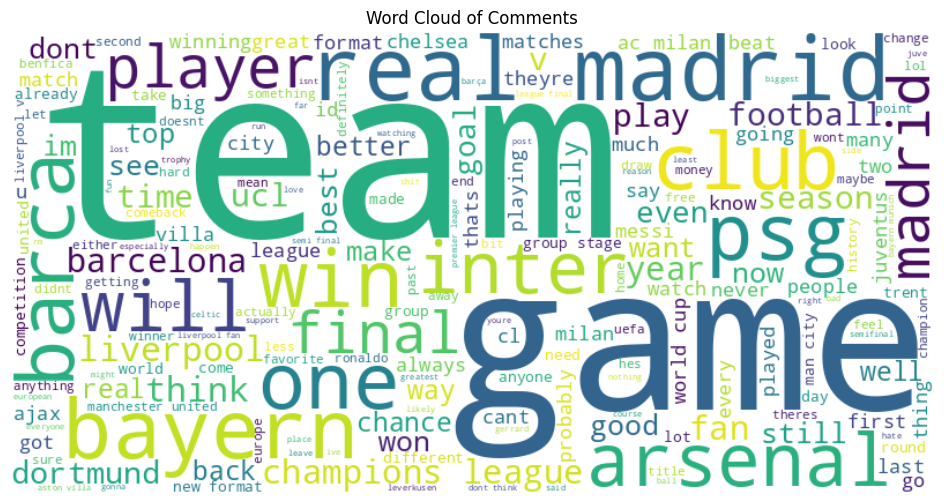

In [ ]:
# Flatten the token list and count word frequencies
all_words = [word for tokens in df["Tokens"] for word in tokens]
word_counts = Counter(all_words)

# Get the 10 most common words
most_common_words = word_counts.most_common(10)
words, counts = zip(*most_common_words)

# Bar Chart of Most Common Words
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color="skyblue", edgecolor="black")
plt.title("Top 10 Most Common Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

# Word Cloud of Most Common Words
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Comments")
plt.show()

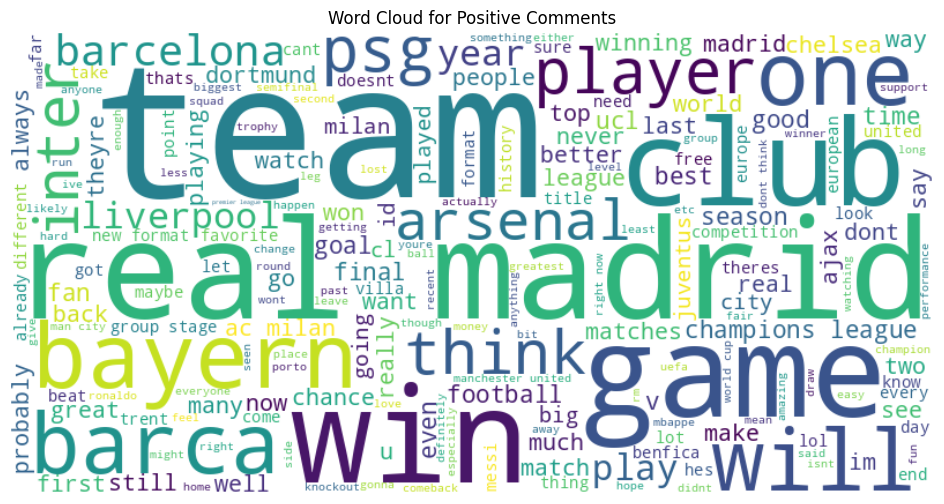

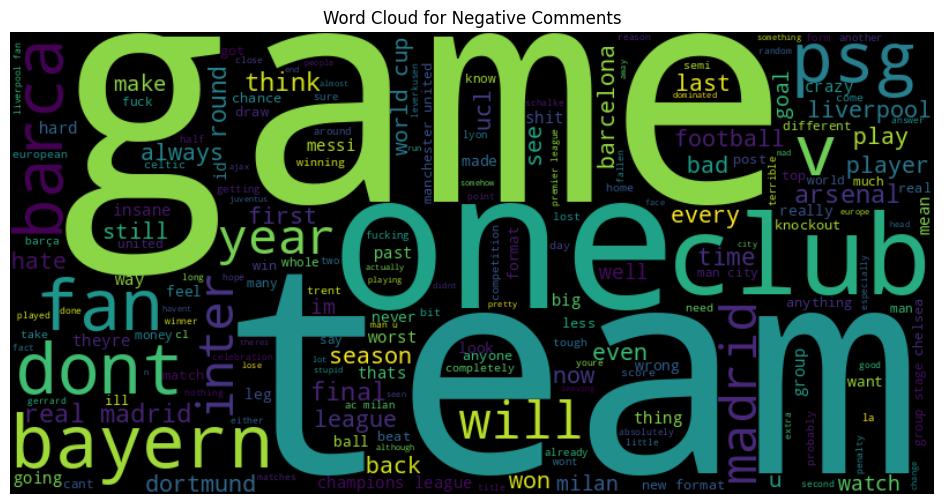

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the dataset (with sentiment categories)
df = pd.read_csv("Football_comments_with_sentiment.csv")

# Ensure valid text data
df = df[df["Comment"].notnull()]
df["Comment"] = df["Comment"].astype(str)

# Split the dataset into positive and negative comments
positive_comments = df[df["Sentiment Category"] == "Positive"]["Comment"]
negative_comments = df[df["Sentiment Category"] == "Negative"]["Comment"]

# Define a function to generate a word cloud
def generate_wordcloud(comments, title, background_color="white"):
    # Join all comments into a single string
    text = " ".join(comments)

    # Create the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color=background_color).generate(text)

    # Plot the word cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {title} Comments")
    plt.show()

# Generate word cloud for positive comments (white background by default)
generate_wordcloud(positive_comments, "Positive", background_color="white")

# Generate word cloud for negative comments (black background)
generate_wordcloud(negative_comments, "Negative", background_color="black")

In [ ]:
!pip install pandas gensim pyLDAvis

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Football_comments_cleaned.csv")

# Ensure valid text data
df = df[df["Comment"].notnull()]
df["Comment"] = df["Comment"].astype(str)

# Tokenize the text
df["Tokens"] = df["Comment"].apply(lambda x: x.split())

# Display first few rows to verify
print(df.head())

                                             Comment  \
0  fellow fans this is a friendly reminder to ple...   
1  liverpool fans are allowed to not like madrid ...   
2             city being good  united being rubbish    
3  what do you mean two dudes shared all ballon d...   
4  definitely messi and ronaldo \nbefore that the...   

                                              Tokens  
0  [fellow, fans, this, is, a, friendly, reminder...  
1  [liverpool, fans, are, allowed, to, not, like,...  
2        [city, being, good, united, being, rubbish]  
3  [what, do, you, mean, two, dudes, shared, all,...  
4  [definitely, messi, and, ronaldo, before, that...  


In [ ]:
from gensim.corpora.dictionary import Dictionary

# Create a dictionary and corpus
dictionary = Dictionary(df["Tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["Tokens"]]

# Show a sample from the corpus
print(corpus[:5])  # [(word_id, word_count), ...]

[[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 3), (32, 1), (33, 1), (34, 1), (35, 1)], [(0, 2), (3, 1), (10, 2), (21, 1), (31, 2), (32, 2), (36, 2), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 4), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 2), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1)], [(62, 2), (63, 1), (64, 1), (65, 1), (66, 1)], [(35, 1), (42, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1)], [(0, 1), (3, 1), (30, 2), (48, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1)]]


In [ ]:
from gensim.models.ldamodel import LdaModel

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42)

# Print the topics
for topic_id, topic_words in lda_model.print_topics():
    print(f"Topic {topic_id}: {topic_words}")

Topic 0: 0.043*"the" + 0.020*"in" + 0.020*"a" + 0.017*"and" + 0.014*"it" + 0.013*"of" + 0.012*"to" + 0.009*"league" + 0.008*"i" + 0.008*"is"
Topic 1: 0.032*"the" + 0.029*"and" + 0.023*"to" + 0.020*"a" + 0.018*"of" + 0.015*"is" + 0.013*"in" + 0.013*"but" + 0.011*"i" + 0.010*"have"
Topic 2: 0.049*"vs" + 0.020*"milan" + 0.017*"liverpool" + 0.016*"barcelona" + 0.014*"ac" + 0.010*"madrid" + 0.009*"man" + 0.008*"final" + 0.007*"bayern" + 0.007*"united"
Topic 3: 0.058*"the" + 0.024*"and" + 0.019*"in" + 0.018*"of" + 0.017*"a" + 0.011*"league" + 0.011*"to" + 0.010*"is" + 0.008*"they" + 0.008*"champions"
Topic 4: 0.038*"the" + 0.026*"to" + 0.022*"a" + 0.020*"in" + 0.016*"i" + 0.016*"and" + 0.013*"they" + 0.013*"is" + 0.012*"it" + 0.011*"of"


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Create visualization
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)  # Displays inline visualization

In [ ]:
pyLDAvis.save_html(vis, 'lda_visualization.html')

In [ ]:
from google.colab import files
files.download('lda_visualization.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>